In [1]:
#https://www.tensorflow.org/tutorials/keras/text_classification_with_hub
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#!pip list
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.7.0
GPU is NOT AVAILABLE


## Downloading the data (only done once)

In [2]:
# Split the training set into 60% and 40%, so we'll end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

## Each example is a sentence representing moveir review and label.
**Label is 0 for negative and 1 for positive. Let's look at the first couple examples:**

In [8]:
train_data.batch

<bound method DatasetV2.batch of <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>>

In [14]:
#each example is a sentence representing movie review and label
#label is 0 for negative and 1 for positive
#looking at first couple examples
train_examples_batch, train_labels_batch = next(iter(train_data.batch(5)))
print(train_examples_batch)
print(train_labels_batch)

tf.Tensor(
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot de

## How do we represent the text data?

**One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have three advantages:**

**1. we don't have to worry about text preprocessing**   
**2. we can benefit from transfer learning**  
**3. the embedding has a fixed size, so it's simpler to process**  

**For this example we will use a pre-trained text embedding model from TensorFlow Hub called google/tf2-preview/gnews-swivel-20dim/1.**

**Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that no matter the length of the input text, the output shape of the embeddings is: (num_examples, embedding_dimension)**

In [15]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

**Now let's build the full model:**

In [23]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


## The layers are stacked sequentially to build the classifier:

**1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The pre-trained text embedding model that we are using (google/tf2-preview/gnews-swivel-20dim/1) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: (num_examples, embedding_dimension).**

**2. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.**

**3. The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.**

**Let's compile the model.**

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
#save the model at this location after every epoch
checkpoint_path = '/Users/benjamin.jones/Desktop/Movie Reviews/cp-{epoch:04d}' #unique name for each saved checkpoint (after every 1 epoch)
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                                save_freq='epoch' #save after every epoch
                                                )
latest = tf.train.latest_checkpoint(checkpoint_dir) #returns file name of latest checkpoint
print(latest)

None


In [20]:
#Optional: loading a saved model
model.load_weights(latest) #loads weights of the most reccent saved model (adjust if latest not desired)

In [25]:
#begin or resume training
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1,
                   callbacks=[cp_callback])


Epoch 1/20
     30/Unknown - 2s 56ms/step - loss: 0.7224 - accuracy: 0.5201
Epoch 00001: saving model to /Users/benjamin.jones/Desktop/Movie Reviews/cp-0001
30/30 [==============================] - 3s 87ms/step - loss: 0.7225 - accuracy: 0.5201 - val_loss: 0.6352 - val_accuracy: 0.6011
Epoch 2/20
29/30 [============================>.] - ETA: 0s - loss: 0.5433 - accuracy: 0.6967
Epoch 00002: saving model to /Users/benjamin.jones/Desktop/Movie Reviews/cp-0002
30/30 [==============================] - 2s 73ms/step - loss: 0.5408 - accuracy: 0.6975 - val_loss: 0.5149 - val_accuracy: 0.7362
Epoch 3/20
29/30 [============================>.] - ETA: 0s - loss: 0.4130 - accuracy: 0.8122
Epoch 00003: saving model to /Users/benjamin.jones/Desktop/Movie Reviews/cp-0003
30/30 [==============================] - 2s 72ms/step - loss: 0.4112 - accuracy: 0.8121 - val_loss: 0.4251 - val_accuracy: 0.7866
Epoch 4/20
29/30 [============================>.] - ETA: 0s - loss: 0.3146 - accuracy: 0.8750
Epoch 000

## Evaluate the model

**Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.**

In [27]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

loss: 0.436
accuracy: 0.854


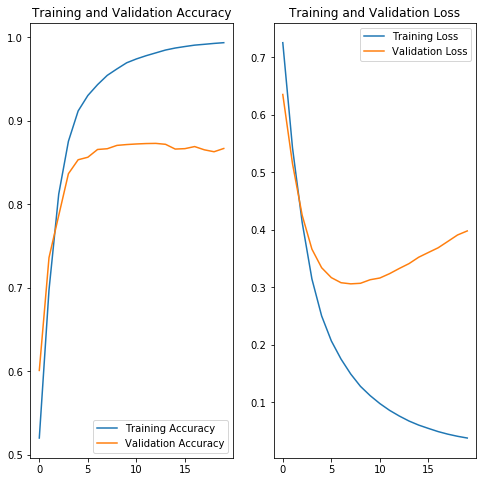

In [26]:
#optional, visual analysis
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()